In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Thu Nov 24 12:45:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    52W / 400W |   3484MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
import tensorflow_hub as hub
import keras

SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED) # Setting seed for a reproducible code.
print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.9.2


In [ ]:
df = np.load('/content/drive/MyDrive/Colab Notebooks/Avaliação - Deep Learning/df224_[0-1].npz')
imagens, rotulos = df['x'], df['y']
rotulos.shape
print("rotulos shape: ", rotulos.shape)
print("rotulos size: ", rotulos.size)
print("rotulos type: ", type(rotulos))

rotulos shape:  (2193,)
rotulos size:  2193
rotulos type:  <class 'numpy.ndarray'>


In [ ]:
# Dividindo a base em treinamento e validação com uso da biblioteca SciKit Learn.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['x'], df['y'], test_size=0.20, random_state=SEED)

In [ ]:
test_nf = np.count_nonzero(y_test == 0)
test_cm = np.count_nonzero(y_test == 1)
train_nf = np.count_nonzero(y_train == 0)
train_cm = np.count_nonzero(y_train == 1)

print(f"""
{20*'='}
Label Distribution
{20*'='}
\n
> Train:
Total: {train_cm + train_nf}
No Findings: {train_nf} ~ {train_nf/(train_nf + train_cm)*100:.4f}%
Cardiomegaly: {train_cm} ~ {train_cm/(train_nf + train_cm)*100:.4f}%
\n
> Test:
Total: {test_cm + test_nf}
No Findings: {test_nf} ~ {test_nf/(test_nf + test_cm)*100:.4f}%
Cardiomegaly: {test_cm} ~ {test_cm/(test_nf + test_cm)*100:.4f}%
""")

del(test_nf, test_cm, train_cm, train_nf)


Label Distribution


> Train:
Total: 1754
No Findings: 875 ~ 49.8860%
Cardiomegaly: 879 ~ 50.1140%


> Test:
Total: 439
No Findings: 225 ~ 51.2528%
Cardiomegaly: 214 ~ 48.7472%



## Warm-up + [cosine | linear] LR


In [ ]:
num_classes = 2
EPOCHS = 100
BATCH_SIZE = 32
# AUTO = tf.data.AUTOTUNE

In [ ]:
# Learning rate scheduling (warm-up + [cosine | linear])
## Reference: https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2


class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        learning_rate = (
            0.5
            * self.learning_rate_base
            * (
                1
                + tf.cos(
                    self.pi
                    * (tf.cast(step, tf.float32) - self.warmup_steps)
                    / float(self.total_steps - self.warmup_steps)
                )
            )
        )

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [ ]:
num_train = len(X_train)
num_test = len(X_test)

In [ ]:
TOTAL_STEPS = int((num_train / BATCH_SIZE) * EPOCHS)
WARMUP_STEPS = 10
INIT_LR = 0.03
WAMRUP_LR = 0.006

print(TOTAL_STEPS)

5481


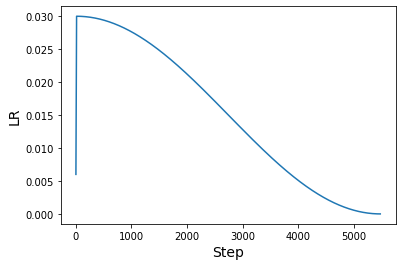

In [ ]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=INIT_LR,
    total_steps=TOTAL_STEPS,
    warmup_learning_rate=WAMRUP_LR,
    warmup_steps=WARMUP_STEPS,
)

lrs = [scheduled_lrs(step) for step in range(TOTAL_STEPS)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [ ]:
optimizer = keras.optimizers.SGD(scheduled_lrs, clipnorm=1.0)
loss = keras.losses.SparseCategoricalCrossentropy()
initializer = keras.initializers.HeNormal(SEED)

## ViT B8

In [ ]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Retornaremos o melhor conjunto de pesos que maximize a acurácia do modelo nos dados de validação
callback_parada = EarlyStopping(monitor='val_accuracy',
                                min_delta = 0.001,
                                patience = 20,
                                verbose = True,
                                mode='max',
                                baseline = None,
                                restore_best_weights=True)

In [ ]:
def plotHistory(history, patience):
  import matplotlib.pyplot as plt

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.plot([history.epoch[-1]-int(patience),history.epoch[-1]-int(patience)],
            plt.ylim(), label='Best Epoch')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.plot([history.epoch[-1]-int(patience),history.epoch[-1]-int(patience)],
            plt.ylim(), label='Best Epoch')
  plt.legend(loc='upper right')
  plt.ylabel('Sparse Categorical Cross Entropy')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [ ]:
## Making tensor dataset to fit vit_s16_fe input shape

x_train = np.expand_dims(X_train, axis=-1)
x_test = np.expand_dims(X_test, axis=-1)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(SEED)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(SEED)

In [ ]:
import tensorflow_hub as hub

def get_model(
    handle="https://tfhub.dev/sayakpaul/vit_s16_fe/1", 
    num_classes=2,
):
    hub_layer = hub.KerasLayer(handle, trainable=False, name = 'vit_s16_fe')

    model = keras.Sequential(
        [
            keras.layers.InputLayer((224, 224, 3)),
            hub_layer,
            keras.layers.Dense(256, activation="relu", kernel_initializer = initializer),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(num_classes, activation="softmax")
            
        ]
    )
    return model

model_ViT = get_model()
model_ViT.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit_l16_fe (KerasLayer)     (None, 384)               21665664  
                                                                 
 dense (Dense)               (None, 256)               98560     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21,764,738
Trainable params: 99,074
Non-trainable params: 21,665,664
_________________________________________________________________


In [ ]:
model_ViT.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
t0 = time.time()
history_VIT = model_ViT.fit(train_dataset,
                    validation_data = test_dataset,
                    epochs=EPOCHS,
                    callbacks=[callback_parada])
print("Training time:", time.time()-t0)

Epoch 1/100
55/55 [==============================] - 33s 293ms/step - loss: 2.0200 - accuracy: 0.5051 - val_loss: 0.7544 - val_accuracy: 0.5376
Epoch 2/100
55/55 [==============================] - 3s 46ms/step - loss: 0.9188 - accuracy: 0.5507 - val_loss: 0.6764 - val_accuracy: 0.5854
Epoch 3/100
55/55 [==============================] - 2s 43ms/step - loss: 0.7754 - accuracy: 0.5804 - val_loss: 0.6883 - val_accuracy: 0.5831
Epoch 4/100
55/55 [==============================] - 2s 45ms/step - loss: 0.7072 - accuracy: 0.5935 - val_loss: 0.6298 - val_accuracy: 0.6446
Epoch 5/100
55/55 [==============================] - 2s 43ms/step - loss: 0.6900 - accuracy: 0.6072 - val_loss: 0.6364 - val_accuracy: 0.6287
Epoch 6/100
55/55 [==============================] - 2s 45ms/step - loss: 0.6688 - accuracy: 0.6249 - val_loss: 0.6114 - val_accuracy: 0.6674
Epoch 7/100
55/55 [==============================] - 2s 45ms/step - loss: 0.6470 - accuracy: 0.6288 - val_loss: 0.6029 - val_accuracy: 0.6743
Epoc

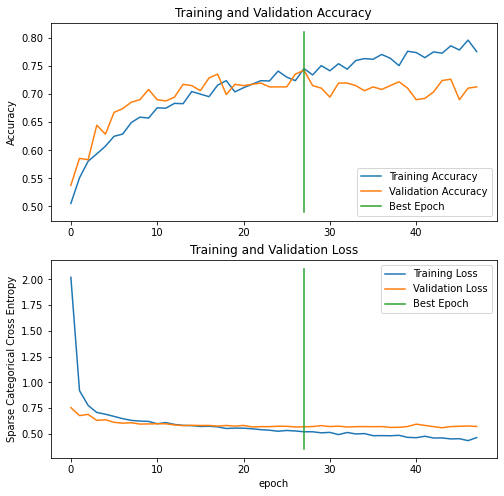

In [ ]:
plotHistory(history_VIT, 20)

14/14 [==============================] - 1s 33ms/step
Prediction time: 1.514786720275879

The average accuracy of the exploring model on Test Data is: 74.2597%


[Text(33.0, 0.5, 'True Label'), Text(0.5, 15.0, 'Predicted Label')]

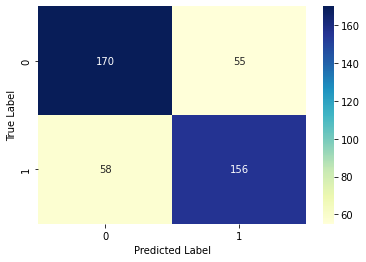

In [ ]:
t0 = time.time()
pred_ViT = model_ViT.predict(X_test)
print("Prediction time:", time.time()-t0)
y_pred_ViT = np.argmax(pred_ViT, axis=1)

print(f'\nThe average accuracy of the exploring model on Test Data is: {accuracy_score(y_pred_ViT, y_test)*100:.4f}%')
hm = sns.heatmap(confusion_matrix(y_test, y_pred_ViT), annot=True, fmt='g', cmap="YlGnBu")
hm.set(xlabel="Predicted Label", ylabel="True Label")

In [ ]:
!nvidia-smi

Thu Nov 24 12:45:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    66W / 400W |   3484MiB / 40536MiB |      4%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------